In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define paths to your dataset
data_dir = '/content/drive/MyDrive/Colab/DenseNet/data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

train_image_dir = os.path.join(train_dir, 'images')
train_label_dir = os.path.join(train_dir, 'labels')
test_image_dir = os.path.join(test_dir, 'images')
test_label_dir = os.path.join(test_dir, 'labels')
valid_image_dir = os.path.join(valid_dir, 'images')
valid_label_dir = os.path.join(valid_dir, 'labels')

In [ ]:
import os
import cv2
import numpy as np

def load_images_and_labels(image_dir, label_dir, threshold=0.5):
    image_paths = os.listdir(image_dir)
    labels = []
    images = []

    for image_name in image_paths:
        image_path = os.path.join(image_dir, image_name)
        label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt'))

        if os.path.exists(label_path):
            with open(label_path, 'r') as label_file:
                label_values = label_file.read().strip().split()  # Split values by space

                # Check if label_values is not empty
                if label_values:
                    label_values = [float(value) for value in label_values]  # Convert values to floats
                    label = np.mean(label_values)  # Calculate the mean of all values

                    # Apply a threshold to convert to binary labels
                    binary_label = 1 if label >= threshold else 0

                    image = cv2.imread(image_path)
                    image = cv2.resize(image, (224, 224))
                    image = image.astype(np.float32) / 255.0

                    labels.append(binary_label)
                    images.append(image)

    return np.array(images), np.array(labels)


In [ ]:
train_images, train_labels = load_images_and_labels(train_image_dir, train_label_dir, threshold=0.5)
valid_images, valid_labels = load_images_and_labels(valid_image_dir, valid_label_dir, threshold=0.5)
test_images, test_labels = load_images_and_labels(test_image_dir, test_label_dir, threshold=0.5)


In [ ]:
# Define DenseNet model
base_model = DenseNet121(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# Freeze layers from the base model (optional)
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=10, batch_size=32)

Epoch 1/10
63/63 [==============================] - 31s 217ms/step - loss: 0.6760 - accuracy: 0.6997 - val_loss: 0.4989 - val_accuracy: 0.7774
Epoch 2/10
63/63 [==============================] - 9s 137ms/step - loss: 0.4049 - accuracy: 0.8221 - val_loss: 0.4455 - val_accuracy: 0.7848
Epoch 3/10
63/63 [==============================] - 7s 116ms/step - loss: 0.3650 - accuracy: 0.8381 - val_loss: 0.4285 - val_accuracy: 0.8015
Epoch 4/10
63/63 [==============================] - 7s 118ms/step - loss: 0.3092 - accuracy: 0.8692 - val_loss: 0.4070 - val_accuracy: 0.8200
Epoch 5/10
63/63 [==============================] - 8s 135ms/step - loss: 0.2706 - accuracy: 0.8847 - val_loss: 0.4812 - val_accuracy: 0.7755
Epoch 6/10
63/63 [==============================] - 7s 116ms/step - loss: 0.2519 - accuracy: 0.8967 - val_loss: 0.4282 - val_accuracy: 0.8200
Epoch 7/10
63/63 [==============================] - 9s 138ms/step - loss: 0.2056 - accuracy: 0.9213 - val_loss: 0.3889 - val_accuracy: 0.8386
Epoch

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

9/9 [==============================] - 3s 348ms/step - loss: 0.4499 - accuracy: 0.7908
Test Loss: 0.44994646310806274
Test Accuracy: 0.7907801270484924


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:
# Function to plot training and validation accuracy/loss curves
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
# Generate predictions on the test set
test_predictions = model.predict(test_images)
test_predictions = np.round(test_predictions).flatten()  # Convert probabilities to binary values (0 or 1)


9/9 [==============================] - 3s 94ms/step


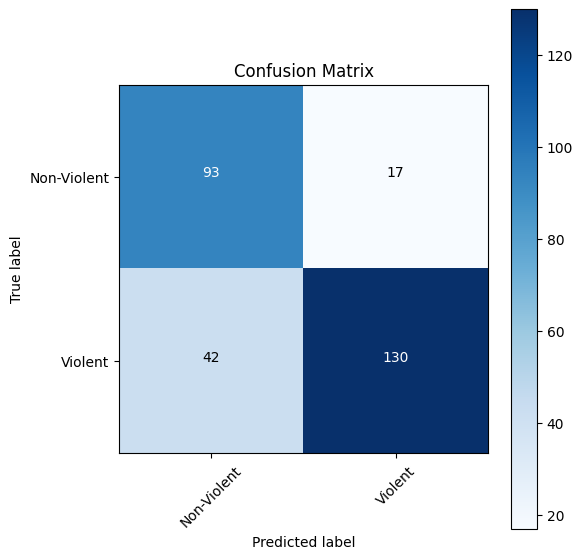

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools  # Import the itertools module

# Function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plot_confusion_matrix(conf_matrix, classes=["Non-Violent", "Violent"], title="Confusion Matrix")
plt.show()


In [ ]:
# Classification report
print(classification_report(test_labels, test_predictions, target_names=["Non-Violent", "Violent"]))


              precision    recall  f1-score   support

 Non-Violent       0.69      0.85      0.76       110
     Violent       0.88      0.76      0.82       172

    accuracy                           0.79       282
   macro avg       0.79      0.80      0.79       282
weighted avg       0.81      0.79      0.79       282



Epoch 1/10
63/63 [==============================] - 9s 149ms/step - loss: 0.1063 - accuracy: 0.9634 - val_loss: 0.3832 - val_accuracy: 0.8590
Epoch 2/10
63/63 [==============================] - 8s 135ms/step - loss: 0.0964 - accuracy: 0.9714 - val_loss: 0.4022 - val_accuracy: 0.8479
Epoch 3/10
63/63 [==============================] - 9s 140ms/step - loss: 0.0693 - accuracy: 0.9825 - val_loss: 0.4343 - val_accuracy: 0.8609
Epoch 4/10
63/63 [==============================] - 9s 140ms/step - loss: 0.0520 - accuracy: 0.9930 - val_loss: 0.4573 - val_accuracy: 0.8442
Epoch 5/10
63/63 [==============================] - 9s 141ms/step - loss: 0.0553 - accuracy: 0.9850 - val_loss: 0.4418 - val_accuracy: 0.8553
Epoch 6/10
63/63 [==============================] - 9s 141ms/step - loss: 0.0484 - accuracy: 0.9900 - val_loss: 0.4330 - val_accuracy: 0.8590
Epoch 7/10
63/63 [==============================] - 9s 138ms/step - loss: 0.0703 - accuracy: 0.9744 - val_loss: 0.4537 - val_accuracy: 0.8516
Epoch 

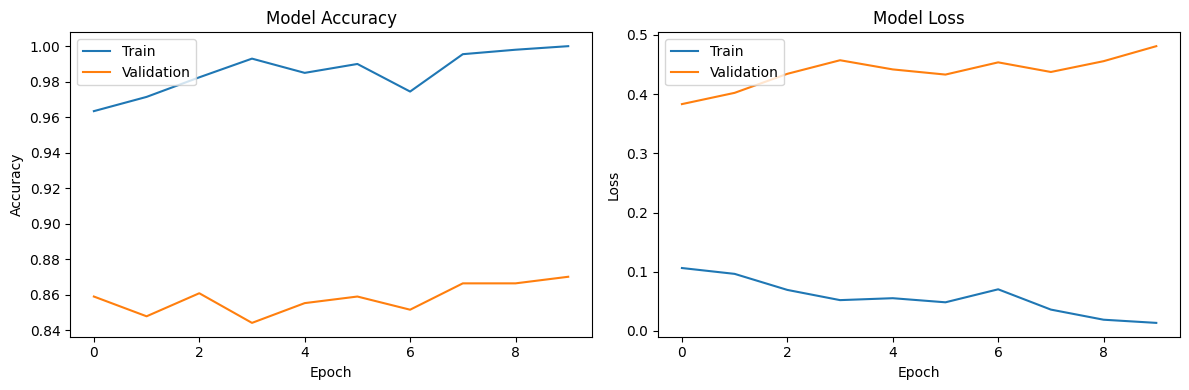

In [ ]:
# Plot training and validation accuracy/loss curves
# Train the model and store the training history
history = model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=10, batch_size=32)
plot_accuracy_loss(history)

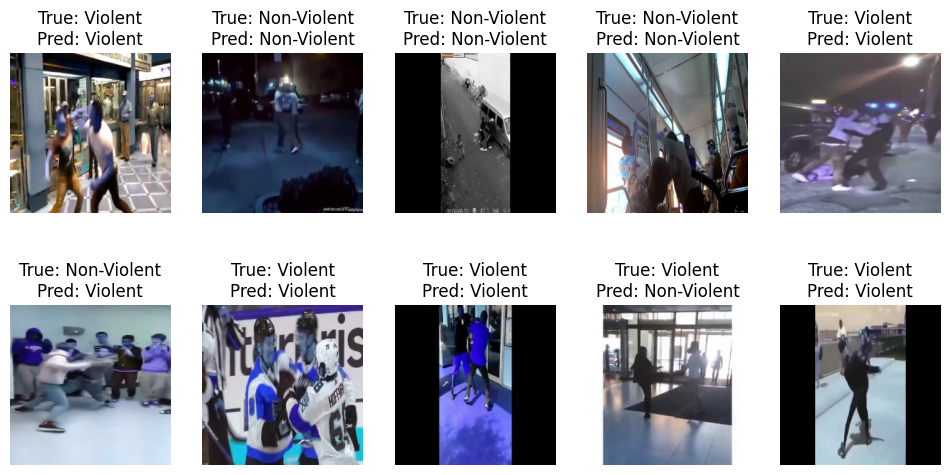

In [ ]:
# Display some test images with their predicted labels
plt.figure(figsize=(12, 6))
for i in range(10):  # Display the first 10 test images
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {['Non-Violent', 'Violent'][test_labels[i]]}\nPred: {['Non-Violent', 'Violent'][int(test_predictions[i])]}")
    plt.axis('off')
plt.show()